In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import qiskit

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy

from PIL import Image

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-10-07 10:01:53,547: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
# Loading our image in the Quantum State
test_image = Image.open('test_4x4_image.tif')
np_test_image = np.array(test_image)

# We need to do this so that we take only a single channel of the color data in the .tif image
test_image_final = []
for row in np_test_image:
    for pixel in row:
        test_image_final.append( pixel[0] / 256)

np_test_image = np.array(test_image_final)

np_test_image = np_test_image.reshape((4,4))
print(np_test_image)


[[0.8125     0.84765625 0.86328125 0.8515625 ]
 [0.88671875 0.89453125 0.22265625 0.8984375 ]
 [0.2890625  0.890625   0.49609375 0.8984375 ]
 [0.43359375 0.89453125 0.38671875 0.4375    ]]


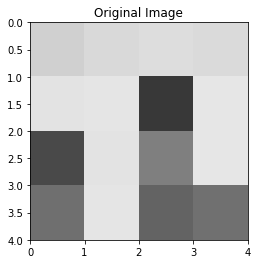

In [4]:
# Function to plot our image
def plot_image4x4(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image4x4(np_test_image, "Original Image")   

[[0.2778443  0.2898664  0.29520956 0.29120219]
 [0.3032243  0.30589588 0.07614002 0.30723167]
 [0.09884845 0.30456009 0.16964532 0.30723167]
 [0.14827268 0.30589588 0.1322432  0.14960847]]


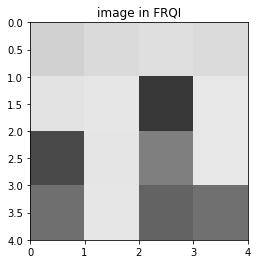

In [5]:
# We need to normalize our input image before passing it as the input quantum state.
def normalize(array):
    rms = np.sqrt(np.sum(np.sum(array**2)))
    ret_array = []
    for i in array:
        ret_array.append( (i * (1/rms)) )
    
    npret_array = np.array(ret_array)
    return npret_array

# The normalized image is too dark, so we brighten it with this method
def plot_image4x4_brightened(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=0.34, cmap='gray')
    plt.show()
    

np_test_image_normalized = normalize(np_test_image)
print(np_test_image_normalized)

plot_image4x4_brightened(np_test_image_normalized, 'image in FRQI')

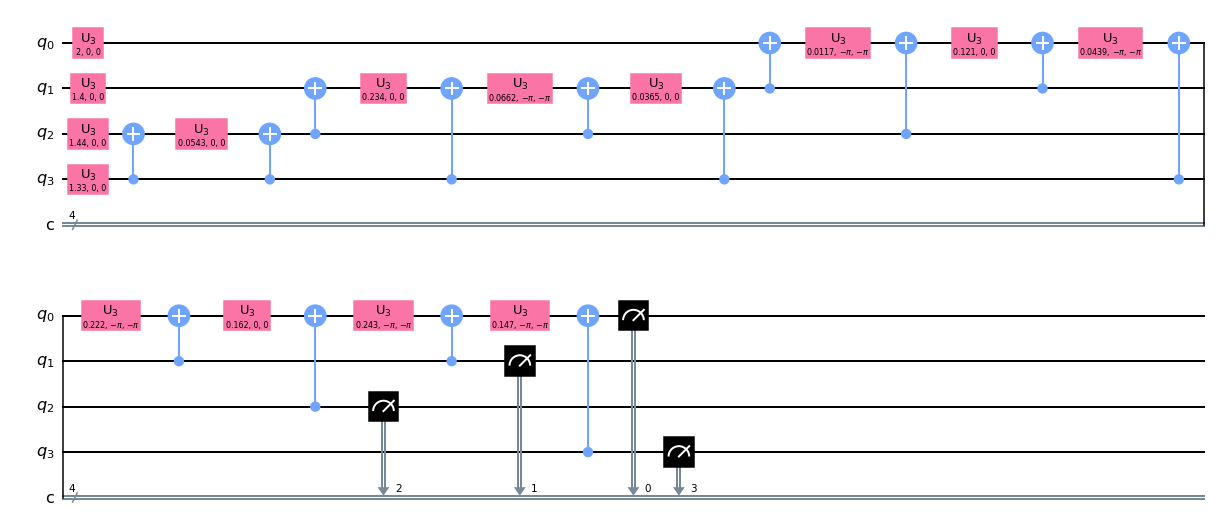

In [6]:
# Our Quantum Circuit that initializes the FRQI image
qc_image = QuantumCircuit(4,4)

qc_image.initialize(np_test_image_normalized.reshape(16))

qc_image.measure(range(4), range(4))

#qc_image = qc_image.decompose().decompose().decompose().decompose().decompose().decompose().decompose()
qc_image = qiskit.compiler.transpile(qc_image, basis_gates=["u1", "u2", "u3", "cx"])


qc_image.draw()

In [7]:
import sys
!{sys.executable} -m pip install mitiq

In [8]:
import mitiq
from qiskit.test.mock import FakeLima
from qiskit.providers.aer.noise import NoiseModel

/tmp/ipykernel_303/2485470514.py:2: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeLima


In [9]:
mitiq.about()


Mitiq: A Python toolkit for implementing error mitigation on quantum computers
Authored by: Mitiq team, 2020 & later (https://github.com/unitaryfund/mitiq)

Mitiq Version:	0.18.0

Core Dependencies
-----------------
Cirq Version:	1.0.0
NumPy Version:	1.20.3
SciPy Version:	1.7.3

Optional Dependencies
---------------------
PyQuil Version:	3.3.1
Qiskit Version:	0.37.1
Braket Version:	Not installed

Python Version:	3.8.13
Platform Info:	Linux (x86_64)


In [10]:
def executor(qc_circuit, shots=4000):
    # For the sake of checking, we'll use a simulator with the same noise model as IBMQ_Lima
    noisy_backend = FakeLima() 

    job = noisy_backend.run(qc_circuit, shots=shots)
    counts = job.result().get_counts()

    # Finding pixel 0000:
    noisy_value = np.sqrt(counts["0000"] / shots)
    return noisy_value  

In [11]:
noisy_value_0000 = executor(qc_image, 4000)
print(noisy_value_0000)

0.30041637771599605


In [74]:
noisy_backend = FakeLima()

job = noisy_backend.run(qc_image, shots=4000)
fake_lima_image_counts = job.result().get_counts()

In [75]:
get_bin = lambda x, n: format(x, 'b').zfill(n)

fake_lima_image_counts = [fake_lima_image_counts[get_bin(i,4)] for i in range(2**4)] 

np_fake_lima_image_counts = np.array(fake_lima_image_counts)
np_fake_lima_image_counts = np_fake_lima_image_counts / 4000
# We need to square root evvery value to determine the amplitudes
np_fake_lima_image_counts = np.sqrt(np_fake_lima_image_counts)
#np_fake_lima_image_counts = normalize(np_fake_lima_image_counts)

np_fake_lima_image_counts = np_fake_lima_image_counts.reshape((4,4))

print(np_fake_lima_image_counts)

print(type(np_fake_lima_image_counts))


[[0.3        0.31064449 0.28679261 0.28284271]
 [0.30124741 0.29874738 0.11937336 0.30331502]
 [0.13133926 0.2770379  0.17535678 0.28635642]
 [0.16733201 0.29240383 0.13322913 0.16431677]]
<class 'numpy.ndarray'>


In [82]:
from mitiq import zne

zne_value = zne.execute_with_zne(qc_image, executor)
print(zne_value)

0.32786115318993436


In [12]:
def executor_array(qc_circuit, shots=4000):
    # For the sake of checking, we'll use a simulator with the same noise model as IBMQ_Lima
    noisy_backend = FakeLima() 

    job = noisy_backend.run(qc_circuit, shots=shots)
    counts = job.result().get_counts()
    
    get_bin = lambda x, n: format(x, 'b').zfill(n)

    counts = [counts[get_bin(i,4)] for i in range(2**4)] 

    np_counts = np.array(counts)
    np_counts = np_counts / 4000
    # We need to square root evvery value to determine the amplitudes
    np_counts = np.sqrt(np_counts)
    #np_counts = normalize(np_counts)

    np_counts = np_counts.reshape((4,4))

    return np_counts  

In [78]:
zne_value = zne.execute_with_zne(qc_image, executor_array)
print(zne_value)

Traceback (most recent call last):
  Input In [79] in <cell line: 1>
    zne_value = zne.execute_with_zne(qc_image, executor_array(bit="0000"))
TypeError: executor_array() got an unexpected keyword argument 'bit'

Use %tb to get the full traceback.


In [20]:
# So executor() can only give a single floating point output! 
# We'll have to go intop more lower level mtiiq stuff instead:

scale_factors = [1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5.]
folded_circuits = [
        mitiq.zne.scaling.folding.fold_all(
        qc_image, scale) for scale in scale_factors
]

shots = 4000
noisy_backend = FakeLima()

job = qiskit.execute(
   experiments=folded_circuits,
   backend=noisy_backend,
   optimization_level=0,  # Important!
   shots=shots
)


    

In [21]:
all_counts = [job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = [np.sqrt((counts.get("0000") / shots)) for counts in all_counts]
print(expectation_values)

# We still need to find the square root! of the pixel

[0.3232645975048923, 0.3122498999199199, 0.33948490393535913, 0.3930648801406709, 0.35601966237835797, 0.3209361307176242, 0.3968626966596886, 0.38340579025361626, 0.38987177379235854]


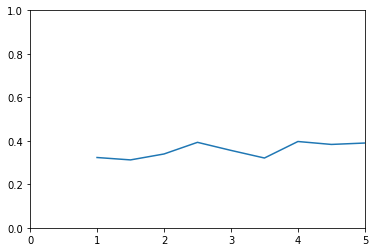

In [22]:
plt.xlim([0, 5])
plt.ylim([0,1])
plt.plot(scale_factors, expectation_values)

In [23]:
from scipy.optimize import curve_fit

def linear_function(x, a, b):
    return a + (b * x)

param, param_cov = curve_fit(linear_function, scale_factors, expectation_values)

print(param)

def linear_function_fitted(x):
    return param[0] + (param[1] * x)

[0.30498772 0.01741744]


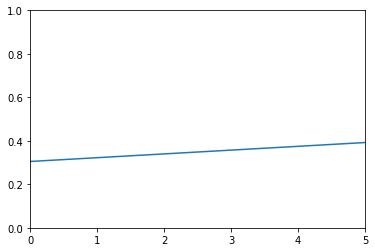

In [24]:
scale_factors_fitted = np.linspace(0, 5, 100)
plt.xlim([0, 5])
plt.ylim([0,1])
plt.plot(scale_factors_fitted, linear_function_fitted(scale_factors_fitted))

In [25]:
print(linear_function_fitted(0))

0.3049877160366604
